<center>
    
 # **ACIT 4610 Mid - Tearm Portfolio Project 1**

 ## **Vehicle Routing Problem Using Quantum - Inspired Evolutionary Algorithms**

 ## **Group nr: 4**

</center>

In [1]:
import math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, NamedTuple
import time

In [2]:
df = pd.read_csv("/content/customers.csv")
df.head()




,id,x,y
0,1,63.942680,2.501076
1,2,27.502932,22.321074
2,3,73.647121,67.669949
3,4,89.217957,8.693883
4,5,42.192182,2.979722


In [3]:
# Defining  the depot at the center of all the customer coordinates

depot_x = df["x"].mean()
depot_y = df["y"].mean()
depot = (depot_x, depot_y)
print(f"\nDepot location: {depot}")


Depot location: (np.float64(52.27493489624376), np.float64(43.63891372903963))


In [4]:
# Preparing a customer coordinates list

coords_df = df[["x","y"]]
customers = list(zip(coords_df["x"], coords_df["y"]))

# Defining distance matrix
def euclidean(a, b):
    return math.hypot(a[0]- b[0], a[1] - b[1])

def distance_matrix(depot, customers):
    pts = [tuple(depot)] + [tuple(c) for c in customers]
    n = len(pts)
    dmat = np.zeros((n,n), dtype = float)
    for i in range(n):
        for j in range(n):
            if i == j:
                dmat[i, j] = 0.0
            else:
                dmat[i, j] = euclidean(pts[i], pts[j])

    return dmat


# Defining VRP instances within the different groups 2 x 3 = 6

In [5]:
class VRPInstance:
    def __init__(self, depot, vehicles, customers):
        self.depot = depot
        self.customers = customers
        self.vehicles = vehicles

# Small Group

Instance1_smallgroup = VRPInstance(depot=depot, vehicles=3, customers=customers[:10])
Instance2_smallgroup = VRPInstance(depot=depot, vehicles=8, customers=customers[:18])

# Medium Group

Instance3_mediumgroup = VRPInstance(depot=depot, vehicles=11, customers=customers[:16])
Instance4_mediumgroup = VRPInstance(depot=depot, vehicles=22, customers=customers[:28])

# Large Group
Instance5_largeroup = VRPInstance(depot=depot, vehicles=32, customers=customers[:38])
Instance6_largegroup = VRPInstance(depot=depot, vehicles=48, customers=customers[:48])


# Representation in order to choose the a chromosome format for the VRP.


class Individual(NamedTuple):
    perm: List[int]  # visit order
    cuts: List[int]  # split it to routes for each vehicle  (could also be put in dic check later)

# random intializer

def random_individual(N: int, V: int, rng:random.Random) -> Individual:
    # random permutation of all customers
    perm = list(range(1, N+1))
    rng.shuffle(perm)

    #choose exactly V-1 unique cut positions
    # here maybe an error handler later

    cuts = sorted(rng.sample(range(1, N), V-1))  # random cuts same number as number of vehicles

    return Individual(perm=perm, cuts=cuts)

# decode into actualy routes

def decode_routes(ind: Individual, V:int) -> List[List[int]]:
    perm = ind.perm
    cuts = ind.cuts

    routes = []
    prev = 0
    for c in cuts:
        routes.append(perm[prev:c])
        prev = c
    routes.append(perm[prev:])

    # maybe sanity test here later
    return routes

def route_distance(route: List[int], dmat) -> float:
    total = 0.0
    prev = 0
    for c in route:
        total += dmat[prev, c]
        prev = c
    total += dmat[prev, 0] # final route to back to depot
    return float(total)

def total_distance(ind: Individual, dmat, V: int) -> float:
    routes = decode_routes(ind, V)
    return sum(route_distance(r, dmat) for r in routes)

# **GA Operators**

In [6]:
def fitness(ind: Individual, dmat, V: int) -> float:
    # inorder to maximize fitness we return the negative of the total distance
    return -total_distance(ind, dmat, V)

def tournament_selection_idx(fitnesses: List[float], k: int, rng: random.Random) -> int:
    # return index of selected parent via k-tournament where higher fitness wins
    cand = [rng.randrange(len(fitnesses)) for i in range(k)]
    return max(cand, key=lambda i: fitnesses[i])

def order_crossover(p1: List[int], p2: List[int], rng: random.Random) -> Tuple[List[int], List[int]]:
    n = len(p1)
    a, b = sorted([rng.randrange(n), rng.randrange(n)])
    def ox(a, b, x, y):
        child = [None]*n
        child[a:b+1] = x[a:b+1]
        fill = [g for g in y if g not in child]
        pos = 0
        for i in range(n):
            if child[i] is None:
                child[i] = fill[pos]; pos +=1
        return child
    return ox(a,b,p1,p2), ox(a,b,p2,p1)

def repair_cuts(cuts: List[int], N: int, V:int, rng: random.Random) -> List[int]:
    clamped = [min(max(1, c), N-1) for c in cuts]
    uniq = sorted(set(clamped))
    need = (V-1)- len(uniq)
    if need > 0:
        #fill missing positions
        pool = [c for c in range(1,N) if c not in uniq]
        add = rng.sample(pool, need)
        uniq = sorted(uniq + add)
    elif need < 0:
        # trim number of cuts if to many
        drop = rng.sample(range(len(uniq)), -need)
        keep = [i for i in range(len(uniq)) if i not in drop]
        uniq = [uniq[i] for i in keep]
    return uniq

def cuts_crossover(c1: List[int], c2: List[int], N: int, V: int, rng: random.Random) -> Tuple[List[int], List[int]]:
    # one point crossover between sorted cuts and then repair
    if not c1 and not c2:
        return [], []
    a = rng.randrange(0, max(len(c1), 1))
    ch1 = sorted(c1[:a] + c2[a:])
    ch2 = sorted(c2[:a] + c1[a:])
    ch1 = repair_cuts(ch1, N, V, rng)
    ch2 = repair_cuts(ch2, N, V, rng)
    return ch1, ch2

def swap_mutation_perm(p: List[int], p_mut:float, rng: random.Random) -> List[int]:
    q = p[:]
    if rng.random() < p_mut and len(q) >= 2:
        i , j = rng.sample(range(len(q)), 2)
        q[i], q[j] = q[j], q[i]
    return q

def jitter_mutation_cuts(cuts: List[int], N:int, V:int, p_mut: float, rng: random.Random) -> List[int]:
    q = cuts[:]
    if rng.random() < p_mut and q:
        i = rng.randrange(len(q))
        shift = rng.choice([1,-1])
        q[i] = min(max(1, q[i] + shift), N-1)
    return repair_cuts(q, N, V, rng)

# **GA Engine**

In [7]:
def genetic_algorithm(dmat, N, V, pop_size, generations, k_tourn, pc, pm_perm, pm_cuts, seed, log_convergence):
    rng = random.Random(seed)

    # init population
    pop = [random_individual(N, V, rng) for _ in range(pop_size)]
    fits = [fitness(ind, dmat, V) for ind in pop]

    best_hist = []  # best in each generation in order to track if the algorithm works

    # evolve
    for _ in range(generations):
        new_pop = []
        while len(new_pop) < pop_size:
            # select parents
            a = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            b = tournament_selection_idx(fits, k=k_tourn, rng=rng)
            p1, p2 = pop[a], pop[b]

            # crossover
            if rng.random() < pc:
                ch1_perm, ch2_perm = order_crossover(p1.perm, p2.perm, rng)
                ch1_cuts, ch2_cuts = cuts_crossover(p1.cuts, p2.cuts, N, V, rng)
            else:
                ch1_perm, ch2_perm = p1.perm[:], p2.perm[:]
                ch1_cuts, ch2_cuts = p1.cuts[:], p2.cuts[:]

            # mutation
            ch1_perm = swap_mutation_perm(ch1_perm, pm_perm, rng)
            ch2_perm = swap_mutation_perm(ch2_perm, pm_perm, rng)
            ch1_cuts = jitter_mutation_cuts(ch1_cuts, N, V, pm_cuts, rng)
            ch2_cuts = jitter_mutation_cuts(ch2_cuts, N, V, pm_cuts, rng)

            # children
            c1 = Individual(perm=ch1_perm, cuts=ch1_cuts)
            c2 = Individual(perm=ch2_perm, cuts=ch2_cuts)
            new_pop.extend([c1, c2])

        # replacement
        pop = new_pop[:pop_size]
        fits = [fitness(ind, dmat, V) for ind in pop]

        if log_convergence:
            best_idx = max(range(pop_size), key=lambda i: fits[i])
            best_hist.append(-fits[best_idx])  # store positive distance

    # best at the end
    best_idx = max(range(pop_size), key=lambda i: fits[i])
    best = pop[best_idx]
    best_dist = -fits[best_idx]

    return best, best_dist, best_hist

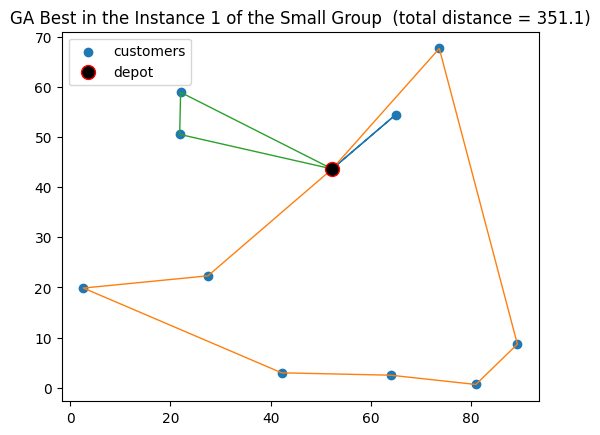

In [8]:
def plot_routes(ind, customers, depot, n_vehicles, number_points=False, title=None):

    routes = decode_routes(ind, n_vehicles)

    # scatter: customers + depot
    xs = [xy[0] for xy in customers]
    ys = [xy[1] for xy in customers]
    plt.figure()
    plt.scatter(xs, ys, label="customers")
    plt.scatter([depot[0]], [depot[1]], marker=".", s=400, label="depot", edgecolors= "red", color ="black", zorder=10)

    # draw each route
    for r in routes:
        if not r:
            continue
        # build path: depot (0) -> r -> depot (0)
        xs_path = [depot[0]] + [customers[i-1][0] for i in r] + [depot[0]]
        ys_path = [depot[1]] + [customers[i-1][1] for i in r] + [depot[1]]
        plt.plot(xs_path, ys_path, linewidth=1.0)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.legend()
    plt.title(title or f"Decoded Routes (vehicles={n_vehicles})")
    plt.show()

# Choosing the instance
instance = Instance1_smallgroup

dmat = distance_matrix(instance.depot, instance.customers)

# Running the GA
best_ind, best_dist, best_hist = genetic_algorithm(dmat, N=len(instance.customers), V=instance.vehicles, pop_size=120, generations=20, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2, seed=0, log_convergence=True)


# Ploting the routes
plot_routes(best_ind, customers=instance.customers, depot=instance.depot, n_vehicles=instance.vehicles, number_points=False,
            title=f"GA Best in the Instance 1 of the Small Group  (total distance = {best_dist:.1f})")

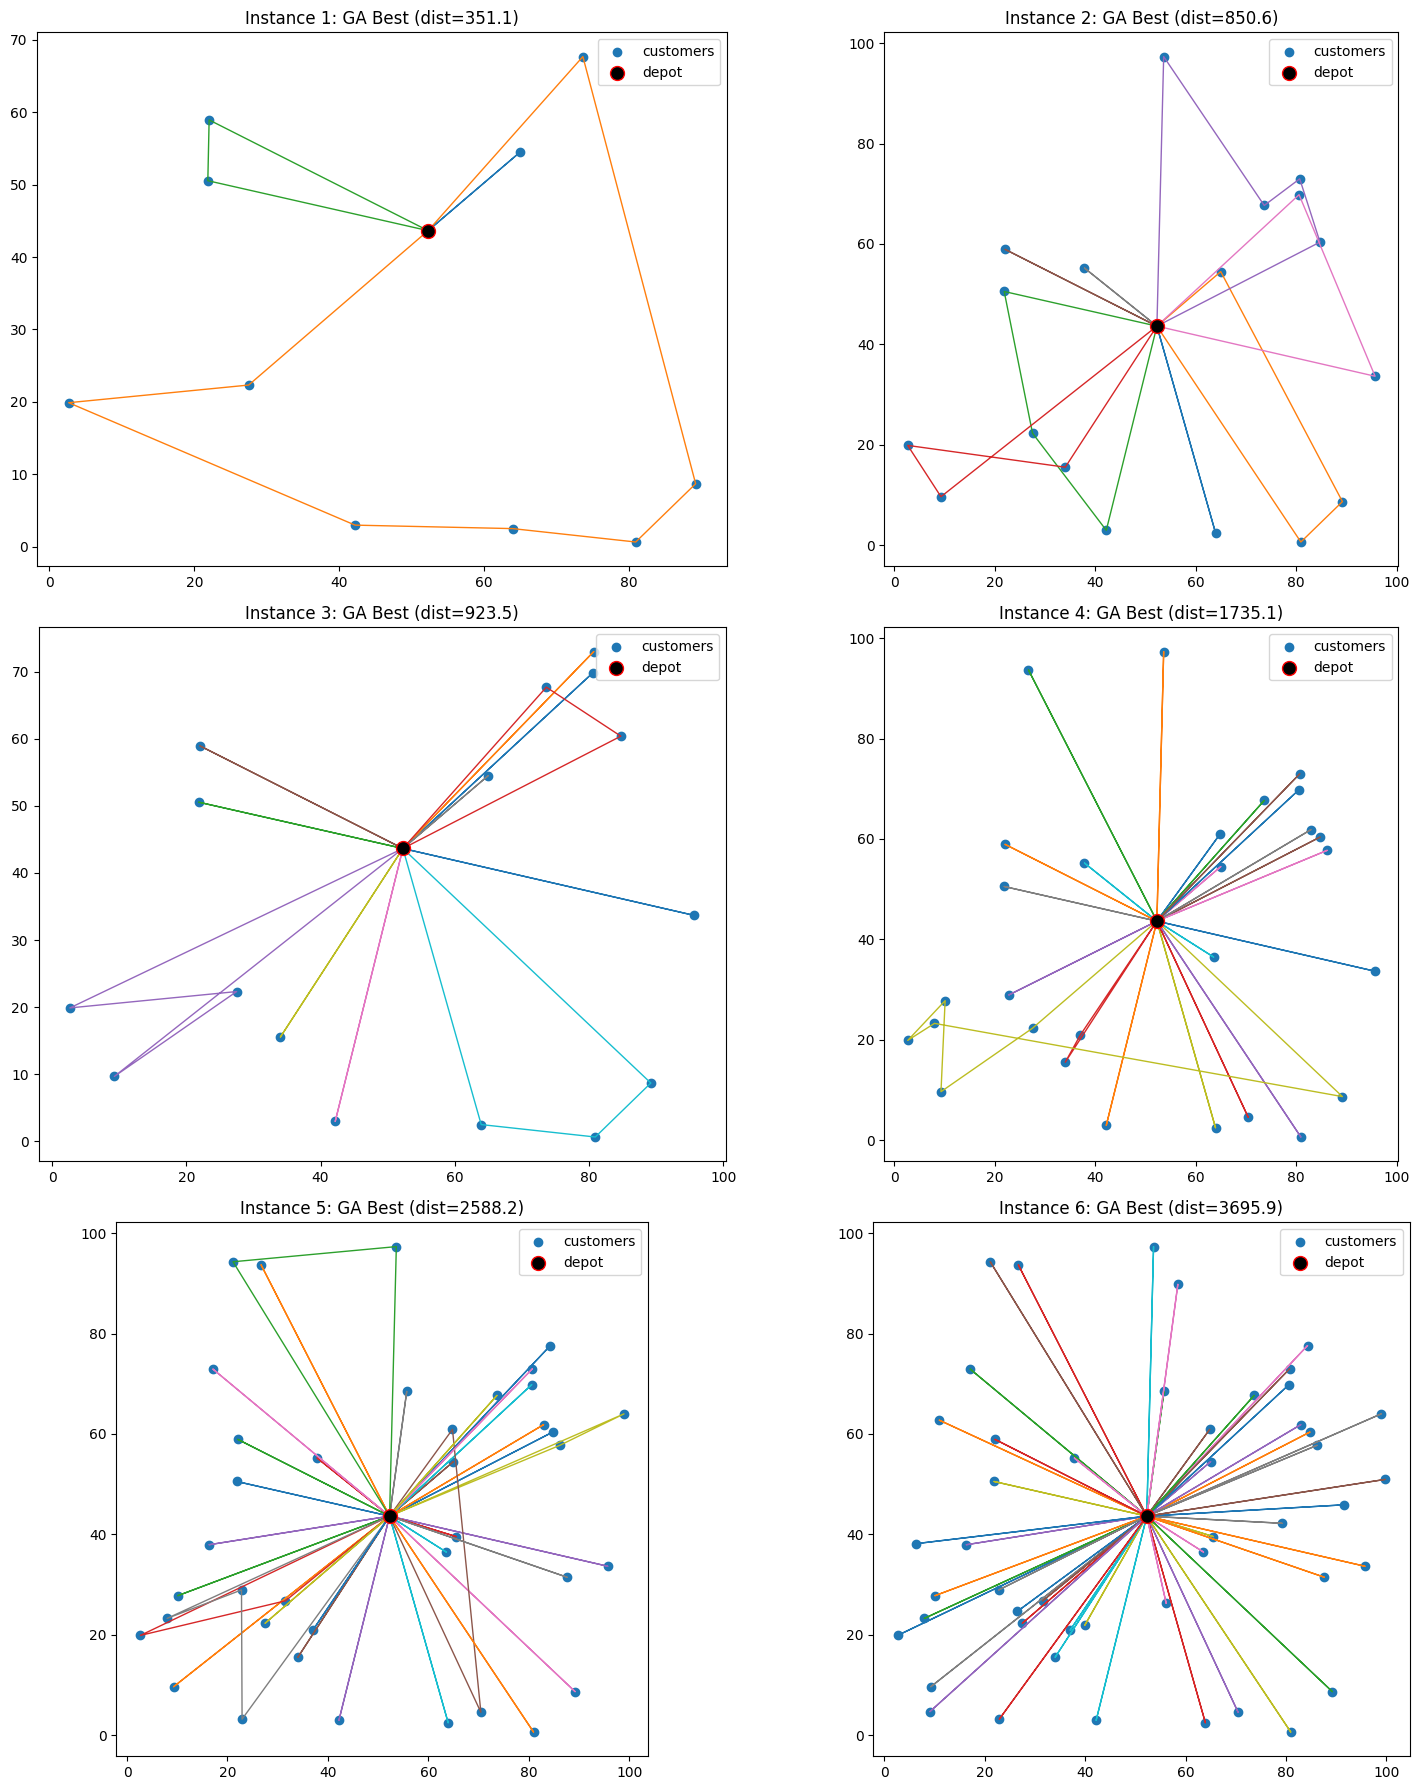

In [9]:
# List of instances
instances = [Instance1_smallgroup, Instance2_smallgroup, Instance3_mediumgroup,
             Instance4_mediumgroup, Instance5_largeroup, Instance6_largegroup]

n_instances = len(instances)
cols = 2
rows = (n_instances + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
axes = axes.flatten()

for idx, instance in enumerate(instances):
    dmat = distance_matrix(instance.depot, instance.customers)

    # Running GA
    best_ind, best_dist, best_hist = genetic_algorithm(dmat, N=len(instance.customers), V=instance.vehicles, pop_size=120, generations=20, k_tourn=3, pc=0.9, pm_perm=0.2, pm_cuts=0.2,  seed=0, log_convergence=True)

    # Decode routes
    routes = decode_routes(best_ind, instance.vehicles)

    # Plot on subplot
    ax = axes[idx]
    xs = [xy[0] for xy in instance.customers]
    ys = [xy[1] for xy in instance.customers]
    ax.scatter(xs, ys, label="customers")
    ax.scatter([instance.depot[0]], [instance.depot[1]], marker=".", s=400, label="depot",
               edgecolors="red", color="black", zorder=10)

    for r in routes:
        if not r:
            continue
        xs_path = [instance.depot[0]] + [instance.customers[i-1][0] for i in r] + [instance.depot[0]]
        ys_path = [instance.depot[1]] + [instance.customers[i-1][1] for i in r] + [instance.depot[1]]
        ax.plot(xs_path, ys_path, linewidth=1.0)

    ax.set_aspect("equal", adjustable="box")
    ax.legend()
    ax.set_title(f"Instance {idx+1}: GA Best (dist={best_dist:.1f})")

# Hiding all the empty subplots
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# **Evaluation Metrics**

**Solution Quality** Which is the total distance off the routes lower the btter

**Computation time** How long the GA takes

**Convergence behavior** how fitness changes over generations

**Consistency** how do the results change when running the GA multiple times

# **Comparison and Analysis**

**Compare metrics such as total distance, GA runtime and convergence behavior of small, medium and large**

**Test 3 sets of GA parameters and run all the 6 instances with all the 3 parameters sets, record metrics and compare the results**

**Analyze if there are any trends? Like does the higher population improve the quality of the solution? Does the generations converagence improve with each generation? Does the size of the instances affect the running time?**

In [10]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define parameter sets
param_sets = {
    "Set1(Small)":   {"pop_size": 60,  "generations": 20, "k_tourn": 3, "pc": 0.9, "pm_perm": 0.2, "pm_cuts": 0.2},
    "Set2(BigPop)":  {"pop_size": 120, "generations": 20, "k_tourn": 3, "pc": 0.9, "pm_perm": 0.2, "pm_cuts": 0.2},
    "Set3(MoreGen)": {"pop_size": 60,  "generations": 50, "k_tourn": 3, "pc": 0.9, "pm_perm": 0.2, "pm_cuts": 0.2},
}

# Experiment Settings
n_runs = 5   # repeat each configuration for consistency

# Instance labels
instance_labels = {
    1: "Small-1",
    2: "Small-2",
    3: "Medium-3",
    4: "Medium-4",
    5: "Large-5",
    6: "Large-6"
}

results = []

for inst_id, instance in enumerate(instances, start=1):
    dmat = distance_matrix(instance.depot, instance.customers)

    for set_name, params in param_sets.items():
        dists = [] # the list of final best distances
        times = []
        all_histories = []

        for run in range(n_runs):
            start = time.time()

            best_ind, best_dist, best_hist = genetic_algorithm(
                dmat,
                N=len(instance.customers),
                V=instance.vehicles,
                seed=run,   # change seed for consistency test
                log_convergence=True,
                **params
            )

            runtime = time.time() - start
            dists.append(best_dist)
            times.append(runtime)
            all_histories.append(best_hist)

        # Aggregate metrics
        results.append({
            "Instance": inst_id,
            "Group": instance_labels[inst_id],
            "ParamSet": set_name,
            "MeanDist": np.mean(dists),
            "StdDist": np.std(dists),
            "MeanRuntime": np.mean(times),
            "Histories": all_histories
        })

# Convert results to DataFrame (summary table)
df_results = pd.DataFrame(results)

# Show results(fisrt 4)
#print(df_results.head())

# save
df_results.to_csv('results.csv', index=False)
#print
df_results



,Instance,Group,ParamSet,MeanDist,StdDist,MeanRuntime,Histories
0,1,Small-1,Set1(Small),336.231378,7.907988,0.048793,"[[456.46632783369455, 452.1620495965824, 414.3..."
1,1,Small-1,Set2(BigPop),349.149748,8.158524,0.093948,"[[379.18860977561656, 412.3682089322458, 395.9..."
2,1,Small-1,Set3(MoreGen),336.231378,7.907988,0.094642,"[[456.46632783369455, 452.1620495965824, 414.3..."
3,2,Small-2,Set1(Small),821.438688,55.329699,0.073682,"[[963.5400561560834, 951.9333569463704, 996.65..."
4,2,Small-2,Set2(BigPop),819.432567,38.942638,0.365172,"[[971.5161298313366, 928.6425168781649, 958.95..."
5,2,Small-2,Set3(MoreGen),727.433075,10.178008,0.340311,"[[963.5400561560834, 951.9333569463704, 996.65..."
6,3,Medium-3,Set1(Small),931.157105,34.251204,0.104109,"[[1020.8293363169081, 1010.7998962298772, 1015..."
7,3,Medium-3,Set2(BigPop),927.788691,18.854294,0.233818,"[[1018.6604622261353, 974.1080940153652, 959.7..."
8,3,Medium-3,Set3(MoreGen),886.078527,9.744721,0.155670,"[[1020.8293363169081, 1010.7998962298772, 1015..."
9,4,Medium-4,Set1(Small),1726.010123,52.069060,0.072001,"[[1829.0539130203465, 1829.0539130203465, 1723..."


In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

# Custom labels for x-axis
instance_labels = {
    1: "Small-1",
    2: "Small-2",
    3: "Medium-3",
    4: "Medium-4",
    5: "Large-5",
    6: "Large-6"
}

def _plot_series(series, series_name, series_index=0, ycol="MeanDist"):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['Instance']
    ys = series[ycol]

    plt.plot(xs, ys, marker='o', label=series_name,
             color=palette[series_index % len(palette)])


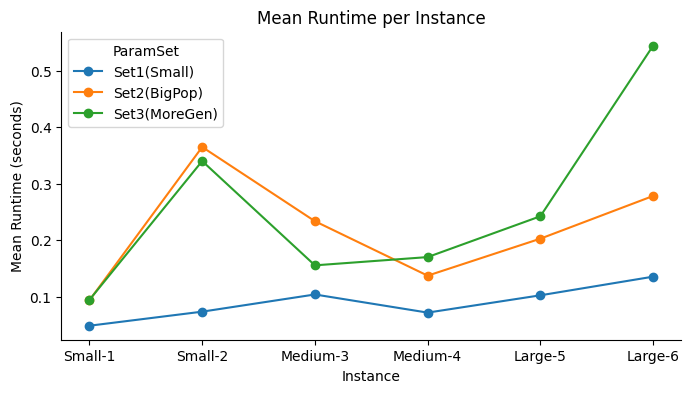

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,4))
df_results_sorted = df_results.sort_values('Instance')

# Plot MeanRuntime for each parameter set
for name, group in df_results_sorted.groupby("ParamSet"):
    plt.plot(group["Instance"], group["MeanRuntime"], marker="o", label=name)

plt.title("Mean Runtime per Instance")
plt.xlabel("Instance")
plt.ylabel("Mean Runtime (seconds)")
plt.xticks(
    ticks=df_results_sorted["Instance"].unique(),
    labels=[instance_labels[i] for i in df_results_sorted["Instance"].unique()]
)
plt.legend(title="ParamSet")
plt.gca().spines[['top','right']].set_visible(False)
plt.show()


**NOTE:** Runtime changes every time, making the graph change... Create a loop for comparison?

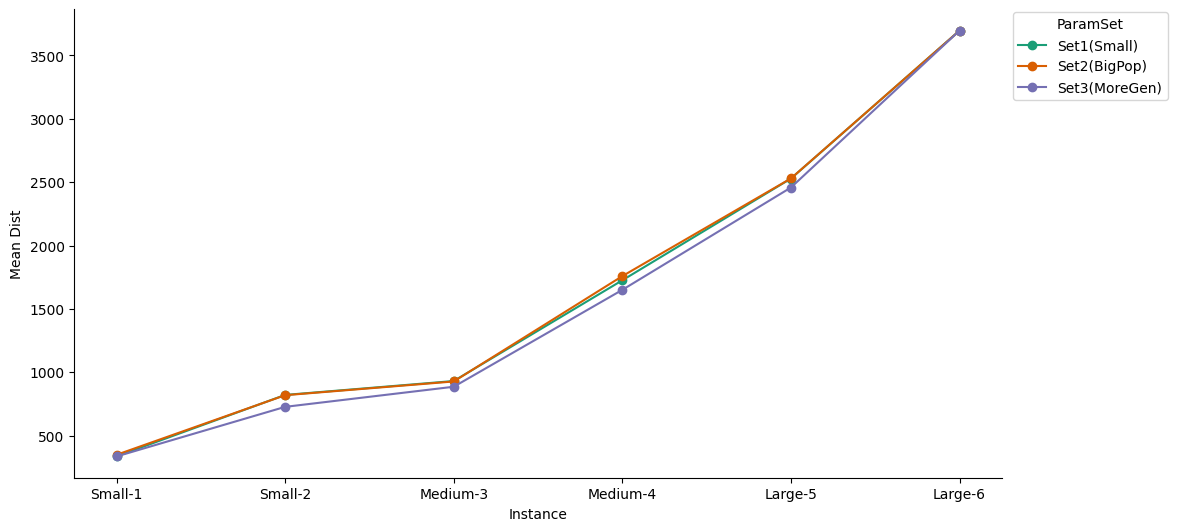

In [13]:

# Mean Distance plot
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Instance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ParamSet')):
    _plot_series(series, series_name, i, ycol="MeanDist")
fig.legend(title='ParamSet', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Instance')
plt.ylabel('Mean Dist')
plt.xticks(ticks=df_sorted['Instance'].unique(),
           labels=[instance_labels[i] for i in df_sorted['Instance'].unique()])
plt.show()


distance increases with instance size. Differences between parameter sets are small, but larger populations or more generations tend to provide slightly better results on the medium and large instances.

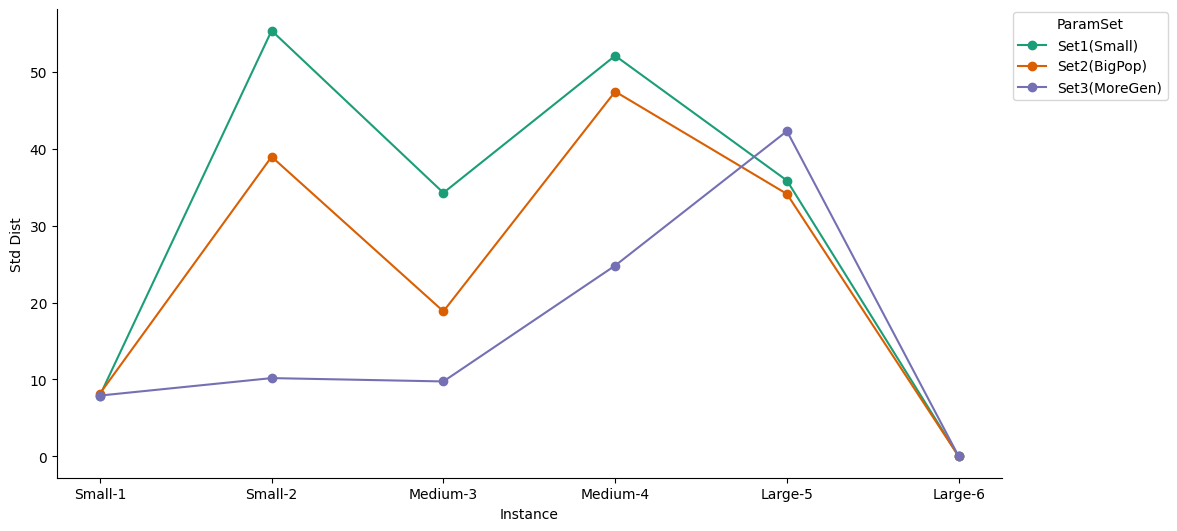

In [14]:

# Final Best distances plot
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_results.sort_values('Instance', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ParamSet')):
    _plot_series(series, series_name, i, ycol="StdDist")
fig.legend(title='ParamSet', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Instance')
plt.ylabel('Std Dist')
plt.xticks(ticks=df_sorted['Instance'].unique(),
           labels=[instance_labels[i] for i in df_sorted['Instance'].unique()])


# plt.yscale("log")
plt.show()


When the standard deviation is small, it means that the GA produces consistent findings each time we run it. When using smaller parameter values, the variability increases in some medium and large situations. But when we give the GA a larger population or run it for more generations, the findings become more stable and repeatable.

## Analysis

**MEDIUM**: The GA finds good solutions for distances between 900 and 1700. When we use smaller settings, they are less stable than small instances, but increasing the GA's population or generations makes it more stable. The issue is that the solutions don't improve much, and it already takes longer to run compared to small cases.

results show that the GA performs well on small instances, producing consistent solutions with short runtimes. As the problem size increases to medium and large, both the runtime and the variation in results grow, which makes sense given the higher complexity. We also see that increasing the population size tends to improve solution quality slightly, especially on larger instances, while adding more generations mostly increases computation time without major gains. Convergence typically happens early in the run, with improvements leveling off after the first few generations.

The GA works quickly and reliably on small problems, but as the instances get larger it takes longer and the results vary more. Bigger populations help improve quality a bit, while more generations mostly just add runtime without much benefit.